# Chapter 4. GMVP Optimization using Hierarchical Clustering 


- __Hyper-parameters to choose from :__

    1. __Scaling methods__ : Standard scaling, Minmax Scaling, or none 
    2. __Dimensionality reduction__ : Principal Component Analysis (PCA), t-distributed stochastic neighbor embedding(t-sne), or none
    3. __How many components to use__ : If we decide to use dimensionality reduction, we also need to decide how many __principal components__ or __t-sne components__ to use.
    4. __Linkage method__ : Several linkage methods exist for hierarchical clustering. e.g. : complete, ward, single...

__Contents__

- [__Step 01. Loading stock data__](#Step-01.-Loading-stock-data)
- [__Step 02. Creating functions for portfolio optimization__](#Step-02.-Creating-functions-for-portfolio-optimization)
- [__Step 03. Portfolio optimization__](#Step-03.-Portfolio-optimization)

---

## Step 01. Loading stock data

__1. Importing required libraries__

In [15]:
# for importing libraries again that is already imported, just in case that any change is made in libraries
%load_ext autoreload
%autoreload 2

# libraries for general work
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

# for computing portfolio performance
from portfolio_performance_function import *

# Disable printing all warnings on python 
import warnings
warnings.filterwarnings("ignore")

# libraries for hierarchical clustering
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.cluster.vq import kmeans, vq

# libraries related with normalization
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

# libraries related with plotting
import seaborn as sns
import matplotlib.pyplot as plt

# libraries for using PCA
from sklearn.decomposition import PCA

# libraries for using t-sne on GPU : https://github.com/rapidsai/cuml
import cudf
from cuml.manifold import TSNE 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


__2. Loading daily price of all stocks for indexing dates : `daily_price_df`__

In [16]:
# Loading
with open('./data/russel1000_daily_price_df.pickle', 'rb') as f:
    daily_price_df = pickle.load(f)
del daily_price_df.index.name

daily_price_df.head(3)

,MMM,ABT,ABMD,ACHC,ATVI,ADBE,AMD,AES,AMG,AFL,...,ZBRA,ZION,XEL,XRX,XLNX,YUM,BRK-B,HEI-A,LGF-A,JW-A
1999-11-01,26.186508,7.625059,10.2500,3.750,1.057096,17.013006,10.15625,22.383265,17.685398,5.895580,...,26.222221,44.172218,8.828288,59.627827,28.284966,4.807233,41.740002,1.899360,1.423901,12.179971
1999-11-02,26.430267,7.187653,10.3125,3.750,1.071191,16.888933,10.28125,22.780302,17.523146,6.068317,...,25.388889,45.481014,8.853581,57.188522,28.801279,4.733161,42.820000,1.891793,1.385417,12.134530
1999-11-03,26.325787,6.963037,10.2500,3.875,1.089984,17.075039,10.65625,22.209560,17.604273,6.150932,...,24.944445,44.920109,8.727110,57.324043,30.417568,4.651680,43.060001,1.755583,1.539352,11.725501


__3. Creating a list of all tickers : `all_tickers_list`__

In [17]:
all_ticker_list = list(daily_price_df.columns)

__4. Loading a grouped daily return data for validation : `daily_return_df_list_validation`__

In [18]:
# Loading
with open('./data/russel1000_daily_return_df_validation.pickle', 'rb') as f:
    daily_return_df_list_validation = pickle.load(f)
    
print(f"Total number of portfolio rebalancing  : {len(daily_return_df_list_validation)}" )
print(f"shape of dataframe : {daily_return_df_list_validation[0].shape}" )

Total number of portfolio rebalancing  : 47
shape of dataframe : (252, 590)


In [19]:
print("---validation---")
print(f"first day date: {daily_return_df_list_validation[1].index[-60].date()}")
print(f"last day date: {daily_return_df_list_validation[-1].index[-1].date()}")

---validation---
first day date: 2000-10-31
last day date: 2011-10-20


In [20]:
# investment dates
investment_date_validation = daily_price_df.loc['2000-10-31':'2011-10-20',:].index
len(investment_date_validation)

2760

__5. Loading a grouped daily return data for test : `daily_return_df_list_test`__

In [21]:
# Loading
with open('./data/russel1000_daily_return_df_test.pickle', 'rb') as f:
    daily_return_df_list_test = pickle.load(f)
    
print(f"Total number of portfolio rebalancing : {len(daily_return_df_list_test)}" )
print(f"shape of dataframe : {daily_return_df_list_test[0].shape}" )

Total number of portfolio rebalancing : 31
shape of dataframe : (252, 590)


In [22]:
print("---test---")
print(f"first day date: {daily_return_df_list_test[1].index[-60].date()}")
print(f"last day date: {daily_return_df_list_test[-1].index[-1].date()}")

---test---
first day date: 2012-10-04
last day date: 2019-11-29


In [23]:
# investment dates
investment_date_test = daily_price_df.loc['2012-10-04':'2019-11-29',:].index
len(investment_date_test)

1800

---

## Step 02. Creating functions for portfolio optimization

- As the clustering approach to GMVP performs portfolio optimization twice, we are going to build two functions
    1. __within cluster optimization : `GMVP_within_cluster`__
    2. __between clusters optimization: `GMVP_between_clusters`__

__1. `GMVP_within_cluster` : This function is used inside another function, `GMVP_between_clusters`.__
- __Input :__  
    1. daily returns of stocks for 1 year
- __Output :__  
    1. daily cluster returns    
    2. within cluster weights   

In [24]:
def GMVP_within_cluster(data_period, index, stock_list_of_cluster):
    
    if data_period == 'validation':
        daily_return_df_list = daily_return_df_list_validation
    elif data_period == 'test':
        daily_return_df_list = daily_return_df_list_test
    
    # slice the data needed
    daily_stock_return_of_cluster_df = daily_return_df_list[index].loc[:, stock_list_of_cluster]
    
    # get the covariance matrix and inverse matrix of covariance matrix respectively
    cov_mat_of_stock_within_cluster_df = daily_stock_return_of_cluster_df.cov()
    cov_mat_of_stock_within_cluster_array = cov_mat_of_stock_within_cluster_df.values
    inv_cov_mat_array = np.linalg.pinv(cov_mat_of_stock_within_cluster_array) # Use pseudo-inverse incase matrix is singular / ill-conditioned

    # construct minimum variance weights
    one_vector_array = np.ones(len(inv_cov_mat_array))
    inv_dot_one_array = np.dot(inv_cov_mat_array, one_vector_array)
    within_cluster_weight_array = inv_dot_one_array/ np.dot(inv_dot_one_array, one_vector_array)
    
    # calculate the daily_return
    daily_weighted_stock_return_df = (daily_stock_return_of_cluster_df * within_cluster_weight_array)
    daily_cluster_return_df = daily_weighted_stock_return_df.sum(axis=1)
    
    return daily_cluster_return_df, within_cluster_weight_array

__2. `GMVP_between_clusters`__
- __Input :__  
    1. daily returns of stocks for 1 year
- __Output :__  
    1. portfolio weights   
    2. daily portfolio returns   
    3. in-sample stdev  
    4. out-of-sample stdev
    5. cluster weights  
    6. daily cluster returns (the same thing from the `GMVP_within_cluster`)

In [28]:
def GMVP_between_clusters(data_period, linkage_method, scaling_method='none', dim_reduction_method='none', no_of_PCA_components = 0, no_of_tsne_components = 0):
    rebalancing_period = 60
    
    ################## creating lists and dictionaries for storing outcomes ##################
    # 1) returns
    daily_portfolio_return_list = []   # daily returns of portfolio
    # 2) stdev
    in_sample_stdev_list = []          # standard deviation of in-sample (252-day-long) daily portfolio returns
    out_of_sample_stdev_list = []      # standard deviation of out-of-sample (60-day-long) daily portfolio returns
    # 3) cluster & stock 
    cluster_and_stock_dict = {}        # 1. cluster_return : 252_daily_returns * 11_clusters
                                       # 2. cluster_weight : weights of each 11 cluster
                                       # 3. cluster_ticker : tickers belonging to each cluster 
                                       # 4. stock_weight   : weights of each individual stock
                                       # 5. daily_return_for_viz 
    ##########################################################################################
    
    if data_period == 'validation':
        daily_return_df_list = daily_return_df_list_validation
    elif data_period == 'test':
        daily_return_df_list = daily_return_df_list_test
    
    for index_no, daily_return_df in enumerate(tqdm(daily_return_df_list)):  

        cluster_weight_dict = {}   # weights of each 11 cluster
        cluster_ticker_dict = {}   # tickers belonging to each cluster 
        stock_weight_within_cluster_dict = {} # weights of each individual stock
        
        ################## 1. normalizing data ##################
        if scaling_method == 'standard_scale':    
            scaled_daily_price_array = (standard_scaler.fit_transform(daily_return_df))
            after_scaling_return_df = pd.DataFrame(scaled_daily_price_array, columns = all_ticker_list).T
        elif scaling_method == 'none':
            after_scaling_return_df = daily_return_df.T
        
        ################## 2. dimensionality reduction ##################
        if dim_reduction_method == 'PCA':
            pca = PCA(n_components=no_of_PCA_components)
            scaled_daily_return_PCA_array = pca.fit_transform(after_scaling_return_df)
            after_dim_reduction_return_df = pd.DataFrame(scaled_daily_return_PCA_array, index = all_ticker_list)  # shape : [stocks * PCs]
        elif dim_reduction_method == 'tsne':
            tsne = TSNE(n_components = no_of_tsne_components)
            scaled_daily_return_tsne_cudf = tsne.fit_transform(after_scaling_return_df.values)
            after_dim_reduction_return_df = pd.DataFrame(scaled_daily_return_tsne_cudf, index = all_ticker_list)
        elif dim_reduction_method == 'none':
            after_dim_reduction_return_df = after_scaling_return_df
            
        ################## 3. hierarchical_clsutering  ################## 
        distance_matrix_array = linkage(after_dim_reduction_return_df, method = linkage_method, metric = 'euclidean')
        after_dim_reduction_return_df['cluster_label'] = fcluster(distance_matrix_array, 11, criterion = 'maxclust')
        # storing clustering results in a dict : within_cluster_ticker_dict
        cluster_label_list = list((after_dim_reduction_return_df.loc[:,'cluster_label'].unique()))
        for cluster_label in cluster_label_list:
            cluster_ticker_dict[cluster_label] = list(after_dim_reduction_return_df[after_dim_reduction_return_df.loc[:,'cluster_label'] == cluster_label].index)
        
        ################## (Optional) For visualization ##################
        pca = PCA(n_components=2)
        daily_return_array_for_viz = pca.fit_transform(after_dim_reduction_return_df.iloc[:,:-1])
        daily_return_df_for_viz = pd.DataFrame(daily_return_array_for_viz, index = all_ticker_list)  # shape : [stocks * PCs]
        daily_return_df_for_viz.loc[: ,'cluster_label'] = after_dim_reduction_return_df.loc[:,'cluster_label']
        daily_return_df_for_viz.rename(columns = {0: 'PC_1',1:'PC_2'}, inplace=True)
        
        # --------------------- #
        #  GMVP within cluster  #
        # --------------------- #
        # GMVP on each cluster using the function 'GMVP_within_cluster' --> to create a matrix of daily returns of clusters
        stock_weight_within_cluster_dict = {}
        daily_cluster_return_dict = {}
        
        ################## 4. computing stock weights within a cluster ##################
        for cluster_label in cluster_label_list:
            daily_cluster_return_series, stock_weight_within_cluster_array = GMVP_within_cluster(data_period, index_no, cluster_ticker_dict[cluster_label])
            daily_cluster_return_dict[cluster_label] = daily_cluster_return_series
            stock_weight_within_cluster_dict[cluster_label] = stock_weight_within_cluster_array

        daily_cluster_return_df = pd.DataFrame.from_dict(daily_cluster_return_dict)
        
        # ---------------------- #
        #  GMVP between clusters #
        # ---------------------- #
        cov_mat_of_cluster_df = daily_cluster_return_df.cov()
        cov_mat_of_cluster_array = cov_mat_of_cluster_df.values
        inv_cov_mat_array = np.linalg.pinv(cov_mat_of_cluster_array) # Use pseudo-inverse incase matrix is singular / ill-conditioned

        ################## 5. computing cluster weights ##################
        one_vector_array = np.ones(len(inv_cov_mat_array))
        inv_dot_one_array = np.dot(inv_cov_mat_array, one_vector_array)
        cluster_weight_array = inv_dot_one_array/ np.dot( inv_dot_one_array , one_vector_array)
        cluster_weight_df = pd.DataFrame(data= cluster_weight_array, columns = ['weight'], index = cluster_label_list)
        
        # compute stdev of portfolio, which can be calculated from daily returns of clusters
        in_sample_variance = np.dot(cluster_weight_array, np.dot(cov_mat_of_cluster_array, cluster_weight_array))
        in_sample_stdev = np.sqrt(in_sample_variance)
        
        ################## 6. computing stock weights in a portfolio (portfolio weights) ##################
        temp_portfolio_weight_list = []

        for cluster_label in cluster_label_list:
            stock_weight_within_sector_array =  cluster_weight_df.loc[cluster_label,'weight'] * stock_weight_within_cluster_dict[cluster_label]
            stock_weight_within_sector_df = pd.DataFrame(stock_weight_within_sector_array, index = cluster_ticker_dict[cluster_label], columns = ['weight'])
            temp_portfolio_weight_list.append(stock_weight_within_sector_df)

        portfolio_weight_df = pd.concat(temp_portfolio_weight_list)
        
        # ---------------------------------------------------------- #
        # Calculating daily return based on GMV optimization results #
        # ---------------------------------------------------------- #
        # we should use 'index+1' ; we optimize portfolio at the time point 'index' and see how it goes for the time period from 'index' to 'index+1'
        if (index_no+1) < len(daily_return_df_list):
            
            # appending to the list only if we invest in the market, following the portfolio optimization
            in_sample_stdev_list.append(in_sample_stdev)
            
            # appending data only if the data is used for calculating next time's return 
            future_daily_return_df = daily_return_df_list[index_no+1]
            future_daily_cluster_return_dict = {}

            for cluster_label in cluster_label_list:

                # 1st optimization - cluster_weight calculated from 'between_cluster GMV'
                cluster_weight = cluster_weight_df.loc[cluster_label,'weight']
                # 2nd optimization - stock_weight calculated from 'inside_cluster GMV'
                stock_weight_within_cluster_array = stock_weight_within_cluster_dict[cluster_label]
                # based on the asset allocation reuslt from 1st optimization and 2nd optimization, now we can compute the each stock's weight
                future_daily_cluster_return_df = (future_daily_return_df.loc[:, cluster_ticker_dict[cluster_label]] * stock_weight_within_cluster_array * cluster_weight)
                future_daily_cluster_return_series = future_daily_cluster_return_df.sum(axis=1)[-rebalancing_period:]
                future_daily_cluster_return_dict[cluster_label] = future_daily_cluster_return_series

            # out-of-sample daily portfolio returns (60 days)
            future_daily_cluster_return_df = pd.DataFrame.from_dict(future_daily_cluster_return_dict)
            daily_portfolio_return_series_60days = future_daily_cluster_return_df.sum(axis=1)
            daily_portfolio_return_list.extend(daily_portfolio_return_series_60days)
            
            # standard deviation of out-of-sample portfolio returns
            out_of_sample_stdev = daily_portfolio_return_series_60days.std()
            out_of_sample_stdev_list.append(out_of_sample_stdev)
            
            # saving outcomes to a dictionary
            cluster_and_stock_dict[index_no] = {'cluster_return' : daily_cluster_return_df,
                                                'cluster_weight' : cluster_weight_df,
                                                'cluster_ticker' : cluster_ticker_dict,
                                                'stock_weight' : portfolio_weight_df,
                                                'daily_return_for_viz' : daily_return_df_for_viz
                                                }
            
    daily_portfolio_return_array = np.array(daily_portfolio_return_list)
    in_sample_stdev_series = pd.Series(in_sample_stdev_list)
    out_of_sample_stdev_series = pd.Series(out_of_sample_stdev_list)
    
    return daily_portfolio_return_array, in_sample_stdev_series, out_of_sample_stdev_series, cluster_and_stock_dict

---

## Step 03. Portfolio optimization
- With custom functions that we have created above, now we can perform GMV portfolio optimization on 591 stocks from either periods, validation period or test period.
- An example is provided for you to learn how we can use custom functions for performing portfolio optimization

__1. Portfolio optimization for the validation or test period__

In [40]:
# data_period = 'validation' or 'test'
# scaling_method = 'standard_scaled' or 'none'
# dim_reduction_method = 'PCA', 'tsne', or 'none'
# linkage_method = 'ward','complete','average','single','centroid','weighted' or 'median'  
# linkage method reference : https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html 

(portfolio_return, in_sample_std, out_of_sample_std, cluster_and_stock_dict) = GMVP_between_clusters(data_period = 'test',
                                                                                                     scaling_method = 'none',
                                                                                                     dim_reduction_method = 'tsne',
                                                                                                     linkage_method = 'average')

__2. Performance check-up__

In [41]:
# in-sample_std
print(f"annualized in-sample stdev : {(in_sample_std).mean()*np.sqrt(252):.4f}")
# out-of-sample_std
print(f"annualized out-of-sample stdev : {(out_of_sample_std).mean()*np.sqrt(252):.4f}")
print('------------------------------')
print(f"annualized_sharpe_ratio : {get_single_sharpe_ratio(portfolio_return)*np.sqrt(252):.4f}")
print(f"annualized_sortino_ratio : {get_single_sortino_ratio(portfolio_return)*np.sqrt(252):.4f}")
print('------------------------------')
# downside_std
print(f"annaulized downside_stdev : {get_single_downside_stdev(portfolio_return)*np.sqrt(252):.4f}")
# MDD
print(f"MDD : {get_maximum_drawdown(portfolio_return)*100:.2f}%")
# CVaR_95
print(f"CVaR_95 : {get_cvar_95(portfolio_return)*100:.2f}%")

annualized in-sample stdev : 0.0395
annualized out-of-sample stdev : 0.0960
------------------------------
annualized_sharpe_ratio : 1.3374
annualized_sortino_ratio : 2.0216
------------------------------
annaulized downside_stdev : 0.0651
MDD : -11.77%
CVaR_95 : -1.06%


__3. Cumulative_wealth__

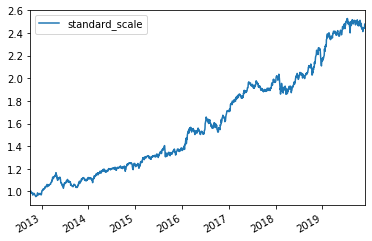

In [42]:
if len(portfolio_return) == 2760:
    dates_index = investment_date_validation
else:
    dates_index = investment_date_test

portfolio_return_df = pd.DataFrame(portfolio_return, index = dates_index, columns = ['standard_scale'])
cumulative_wealth_df = (portfolio_return_df+1).cumprod()
cumulative_wealth_df.plot()

__4. Visualization of daily returns of stocks using two principal components__

In [43]:
# first period of validation period
cluster_and_stock_dict[0]['daily_return_for_viz'].head(3)

,PC_1,PC_2,cluster_label
MMM,1.024949,0.333027,8
ABT,-18.107586,-3.797674,10
ABMD,7.626936,-16.734718,5


In [44]:
daily_return_for_viz = cluster_and_stock_dict[0]['daily_return_for_viz']
daily_return_for_viz['cluster_label'] = 'cluster_' + daily_return_for_viz['cluster_label'].astype(str)
daily_return_for_viz.head(3)

,PC_1,PC_2,cluster_label
MMM,1.024949,0.333027,cluster_8
ABT,-18.107586,-3.797674,cluster_10
ABMD,7.626936,-16.734718,cluster_5


In [45]:
daily_return_for_viz.loc[:,'cluster_label'].value_counts()

cluster_8     129
cluster_10    105
cluster_4      89
cluster_2      82
cluster_3      39
cluster_5      39
cluster_7      27
cluster_11     27
cluster_6      22
cluster_9      22
cluster_1       9
Name: cluster_label, dtype: int64

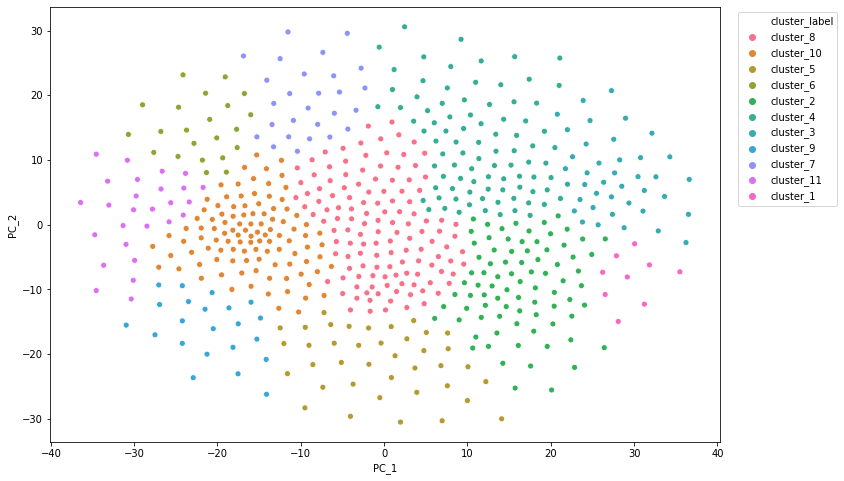

In [46]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='PC_1', y='PC_2', hue="cluster_label", data=daily_return_for_viz)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2)

__5. Difference between `in-sample stdev` and `out-of-sample stdev`__

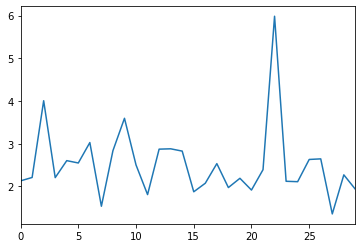

In [47]:
(pd.Series(out_of_sample_std)/in_sample_std).plot()

---